# What is better? A small set of items with many labels or a large set of items with few labels?

* 100 items, each with 100 labels, random sample
* 100 items, each with 100 labels, uniform sample
* 1000 items, each with 3 labels, random sample
* 1000 items, each with 3 labels, uniform sample

In [1]:
import sys
from os.path import dirname, abspath

sys.path.append(dirname(abspath('')))

In [2]:
from collections import Counter
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression

from scipy.stats import beta, uniform

from pyquantifier.data import Item, Dataset
from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.calibration_curve import PlattScaling
from pyquantifier.plot import *

### Data Format

|        | pos | neg | gender |   age |
|--------|-----|-----|--------|-------|
| item 1 | 0.2 | 0.8 | female | young |
| item 2 | 0.3 | 0.7 | female |   old |
|        |     |     |        |       |
| item n | 0.9 | 0.1 |   male |   old |

In [3]:
all_labels = ['pos', 'neg']
all_genders = ['female', 'male']
all_ages = ['young', 'old']

# Generate 10000 items which pos scores follow the mixture distribution
mix_rv = MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[2, 8])
simulated_pos_scores = mix_rv.generate_data(10000)

true_calibration_curve = PlattScaling()
w = 21.92
b = -14.61
true_calibration_curve.set_params(w, b)

items = []
gt_label_dict = {}
for idx, pos_score in enumerate(simulated_pos_scores):
    item = Item(uid=idx+1, labels=all_labels, probs=[pos_score, 1-pos_score], gender=np.random.choice(all_genders), age=np.random.choice(all_ages))
    items.append(item)

    gt_label_dict[item.uid] = true_calibration_curve.get_calibrated_prob(pos_score)[0]

dataset = Dataset(items=items, labels=all_labels)
dataset.df.shape


(10000, 5)

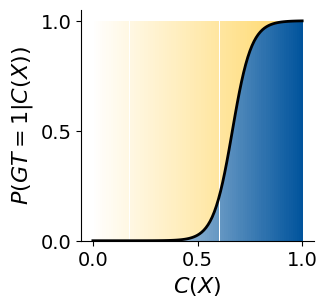

In [4]:
true_calibration_curve.plot()

In [5]:
def select_and_annotate_dataset(dataset, gt_label_dict, n, strategy):
    # strategy options are 'random', 'uniform', 'neyman'
    selected_dataset, selection_weights = dataset.select_sample_for_annotation(n=n, strategy=strategy, bins=10)
    annotated_labels = [gt_label_dict[uid] for uid in selected_dataset.df['uid'].values.tolist()]
    selected_dataset.annotate_sample(annotated_labels)
    return selected_dataset, selection_weights

In [6]:
def get_majority_vote(lst):
    return Counter(lst).most_common(1)[0][0]

In [7]:
def train_linear_regression(dataset):
    train_CX = dataset.df['pos'].values.reshape(-1, 1)
    train_GT = dataset.df['gt_label'].values
    print(len(train_GT), len(train_CX))
    linear_reg_model = LinearRegression(fit_intercept=True).fit(train_CX, train_GT)

    prob_cali_obj = PlattScaling()
    prob_cali_obj.set_params(linear_reg_model.coef_, linear_reg_model.intercept_)

    prob_cali_obj.plot()

    return prob_cali_obj

In [8]:
def train_logistic_regression(dataset):
    train_CX = dataset.df['pos'].values.reshape(-1, 1)
    train_GT = dataset.df['gt_label2'].values
    print(len(train_GT), len(train_CX))
    logistic_reg_model = LogisticRegression(fit_intercept=True).fit(train_CX, train_GT)

    prob_cali_obj = PlattScaling()
    prob_cali_obj.set_params(logistic_reg_model.coef_, logistic_reg_model.intercept_)

    prob_cali_obj.plot()

    return prob_cali_obj

### 1. Random sample, few items, many labels per item

In [9]:
few_random_selected_dataset, _ = select_and_annotate_dataset(dataset, gt_label_dict, n=100, strategy='random')
few_random_selected_dataset.df['gt_label2'] = few_random_selected_dataset.df.apply(lambda row: get_majority_vote(np.random.choice(all_labels, size=199, p=[row['gt_label'], 1-row['gt_label']])), axis=1)

100 100


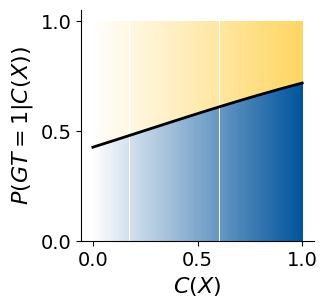

In [10]:
few_random_linear_cc = train_linear_regression(few_random_selected_dataset)

100 100


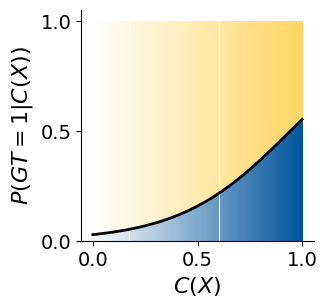

In [11]:
few_random_logistic_cc = train_logistic_regression(few_random_selected_dataset)

In [13]:
few_random_selected_dataset.df.head()

,uid,pos,neg,gender,age,gt_label,gt_label2
7815,7816,0.269762,0.730238,female,young,0.000167,neg
8952,8953,0.312328,0.687672,male,old,0.000425,neg
1804,1805,0.334755,0.665245,male,old,0.000694,neg
6545,6546,0.60344,0.39656,female,old,0.200593,neg
6244,6245,0.130173,0.869827,female,old,0.000008,neg


### 2. Few items, many labels per item

In [14]:
few_uniform_selected_dataset, _ = select_and_annotate_dataset(dataset, gt_label_dict, n=100, strategy='uniform')
few_uniform_selected_dataset.df['gt_label2'] = few_uniform_selected_dataset.df.apply(lambda row: get_majority_vote(np.random.choice(all_labels, size=199, p=[row['gt_label'], 1-row['gt_label']])), axis=1)

100 100


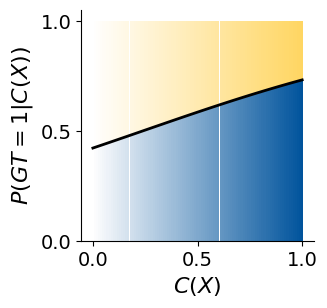

In [15]:
few_uniform_linear_cc = train_linear_regression(few_uniform_selected_dataset)

100 100


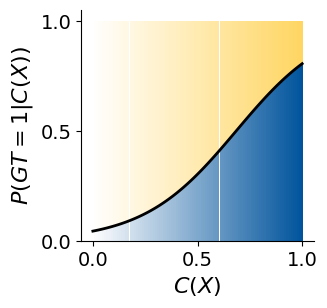

In [16]:
few_uniform_logistic_cc = train_logistic_regression(few_uniform_selected_dataset)

In [17]:
Counter(few_uniform_selected_dataset.df.index.get_level_values(0).to_list())

Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10})

### 3. Many items, few labels per item

In [18]:
many_random_selected_dataset, _ = select_and_annotate_dataset(dataset, gt_label_dict, n=3000, strategy='random')
many_random_selected_dataset.df['gt_label2'] = many_random_selected_dataset.df.apply(lambda row: get_majority_vote(np.random.choice(all_labels, size=3, p=[row['gt_label'], 1-row['gt_label']])), axis=1)

3000 3000


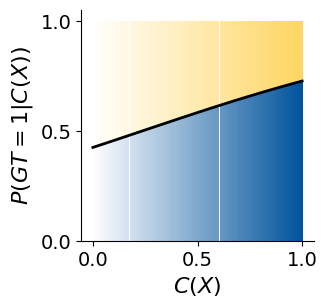

In [19]:
many_random_linear_cc = train_linear_regression(many_random_selected_dataset)

3000 3000


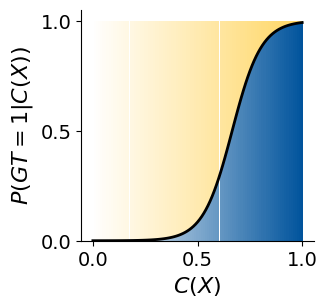

In [20]:
many_random_logistic_cc = train_logistic_regression(many_random_selected_dataset)

### 4. Many items, few labels per item

In [21]:
many_uniform_selected_dataset, _ = select_and_annotate_dataset(dataset, gt_label_dict, n=3000, strategy='uniform')
many_uniform_selected_dataset.df['gt_label2'] = many_uniform_selected_dataset.df.apply(lambda row: get_majority_vote(np.random.choice(all_labels, size=3, p=[row['gt_label'], 1-row['gt_label']])), axis=1)

3000 3000


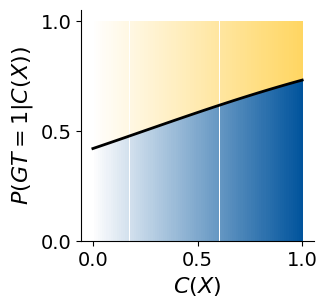

In [22]:
many_uniform_linear_cc = train_linear_regression(many_uniform_selected_dataset)

3000 3000


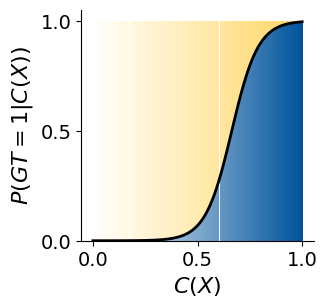

In [23]:
many_uniform_logistic_cc = train_logistic_regression(many_uniform_selected_dataset)

In [24]:
Counter(many_uniform_selected_dataset.df.index.get_level_values(0).to_list())

Counter({0: 300,
         1: 300,
         2: 300,
         3: 300,
         4: 300,
         5: 300,
         6: 300,
         7: 300,
         8: 300,
         9: 300})

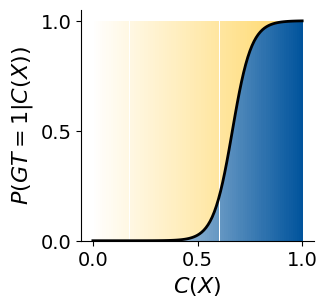

In [25]:
true_calibration_curve.plot()

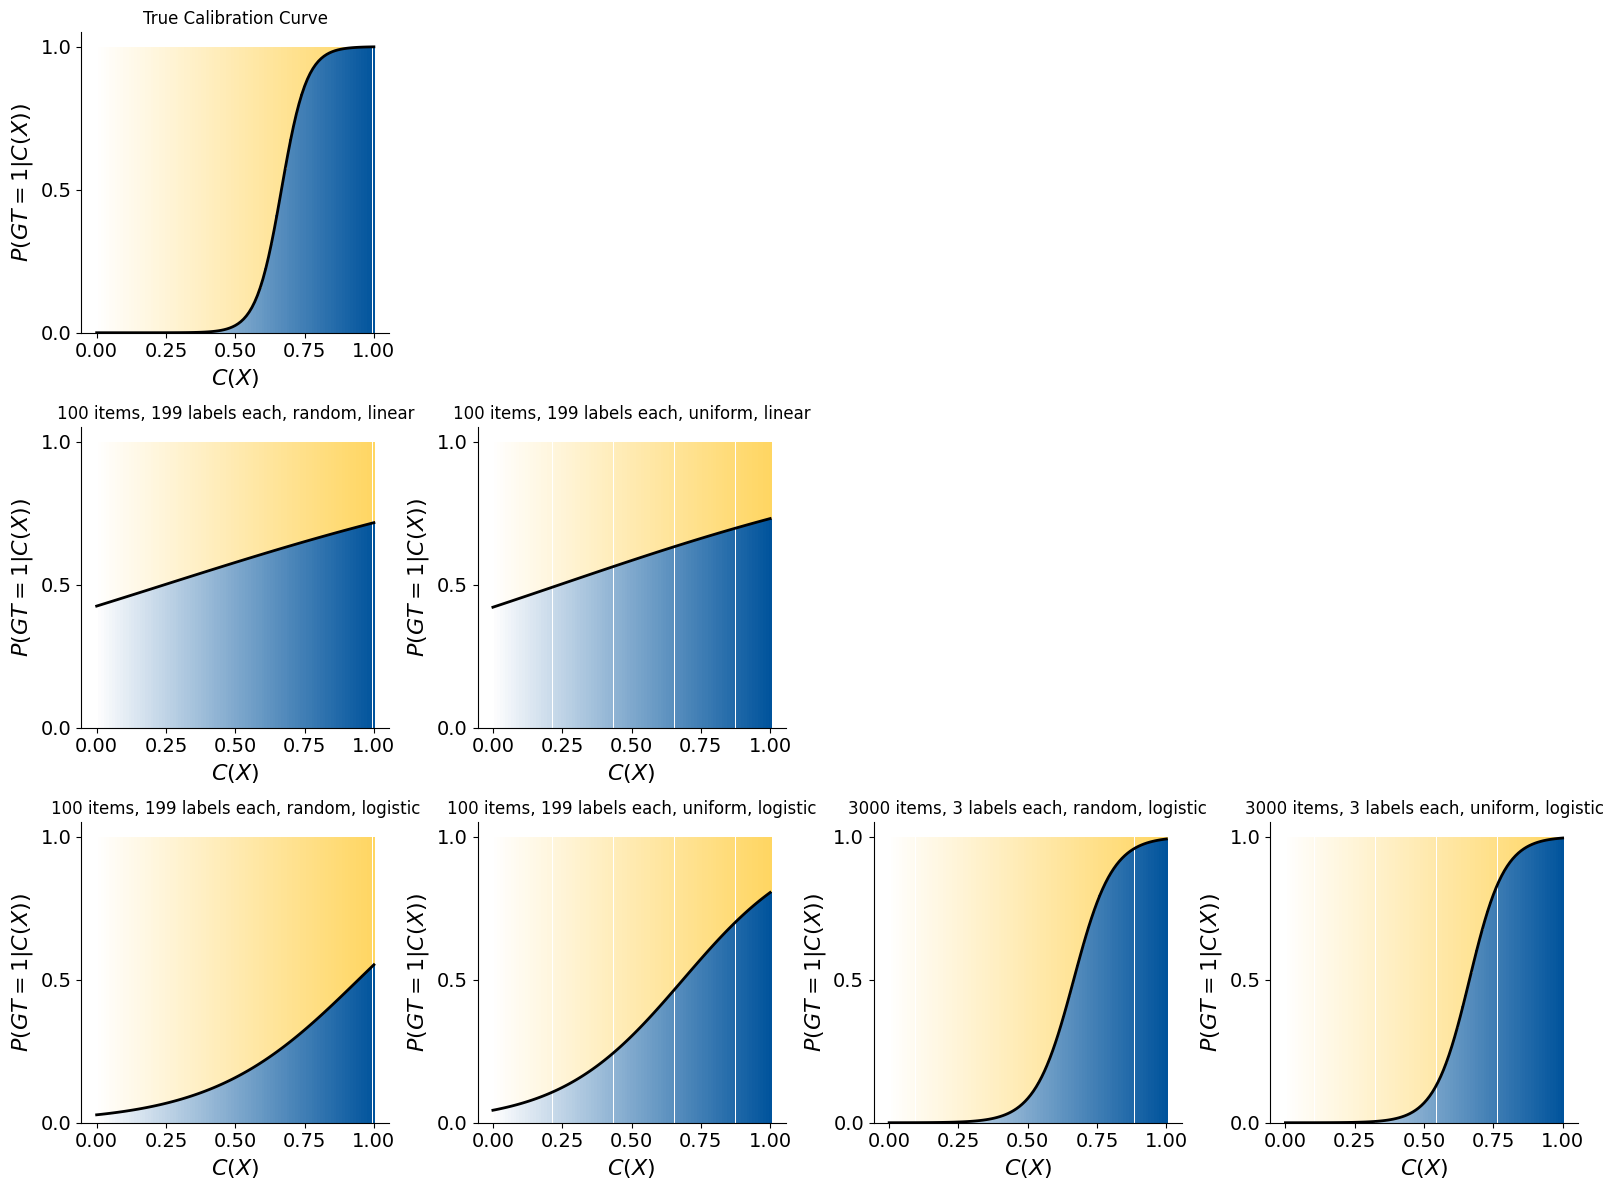

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

true_calibration_curve.plot(ax=axes[0][0])
ax=axes[0][0].set_title('True Calibration Curve')

few_random_linear_cc.plot(ax=axes[1][0])
ax=axes[1][0].set_title('100 items, 199 labels each, random, linear')
few_random_logistic_cc.plot(ax=axes[2][0])
ax=axes[2][0].set_title('100 items, 199 labels each, random, logistic')

few_uniform_linear_cc.plot(ax=axes[1][1])
ax=axes[1][1].set_title('100 items, 199 labels each, uniform, linear')
few_uniform_logistic_cc.plot(ax=axes[2][1])
ax=axes[2][1].set_title('100 items, 199 labels each, uniform, logistic')

# many_random_linear_cc.plot(ax=axes[1][2])
# ax=axes[1][2].set_title('3000 items, 3 labels each, random, linear')
many_random_logistic_cc.plot(ax=axes[2][2])
ax=axes[2][2].set_title('3000 items, 3 labels each, random, logistic')

# many_uniform_linear_cc.plot(ax=axes[1][3])
# ax=axes[1][3].set_title('3000 items, 3 labels each, uniform, linear')
many_uniform_logistic_cc.plot(ax=axes[2][3])
ax=axes[2][3].set_title('3000 items, 3 labels each, uniform, logistic')

for ax in axes.ravel():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major')

axes[0][1].remove()
axes[0][2].remove()
axes[0][3].remove()
axes[1][2].remove()
axes[1][3].remove()

plt.tight_layout()

## Recover the original class density functions

In [31]:
uniform_selection_weights

[0.21551724137931033,
 0.10875475802066341,
 0.10416666666666667,
 0.13360053440213762,
 0.20040080160320642,
 0.32310177705977383,
 0.49875311720698257,
 0.43478260869565216,
 0.2680965147453083,
 0.33783783783783783]

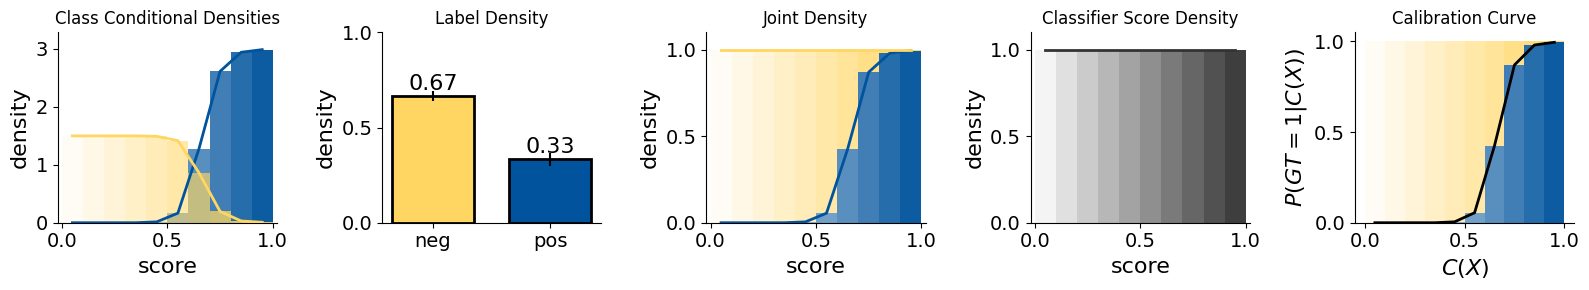

In [32]:
uniform_selected_dataset.profile_dataset(num_bin=10)

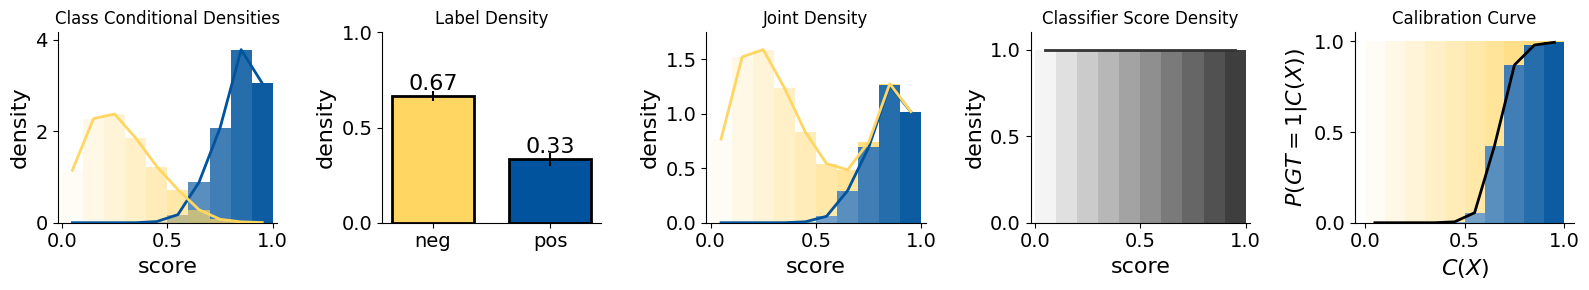

In [33]:
uniform_selected_dataset.profile_dataset(num_bin=10, selection_weights=uniform_selection_weights)

### An alternative way of using observed classifier score density and fitted calibration curve

In [34]:
fitted_calibration_curve = uniform_selected_dataset.generate_calibration_curve(method='platt scaling')

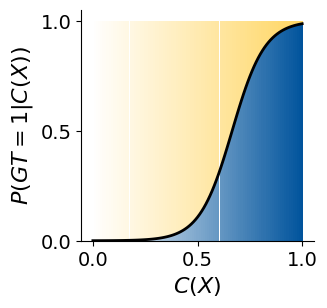

In [35]:
fitted_calibration_curve.plot()

In [41]:
original_classifier_score_density = dataset.infer_classifier_score_distribution(num_bin=20)

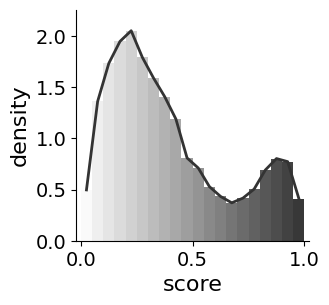

In [42]:
original_classifier_score_density.plot()

In [43]:
original_classifier_score_density.num_bin

20

In [44]:
original_joint_distribution = ExtrinsicJointDistribution(labels, original_classifier_score_density, fitted_calibration_curve)

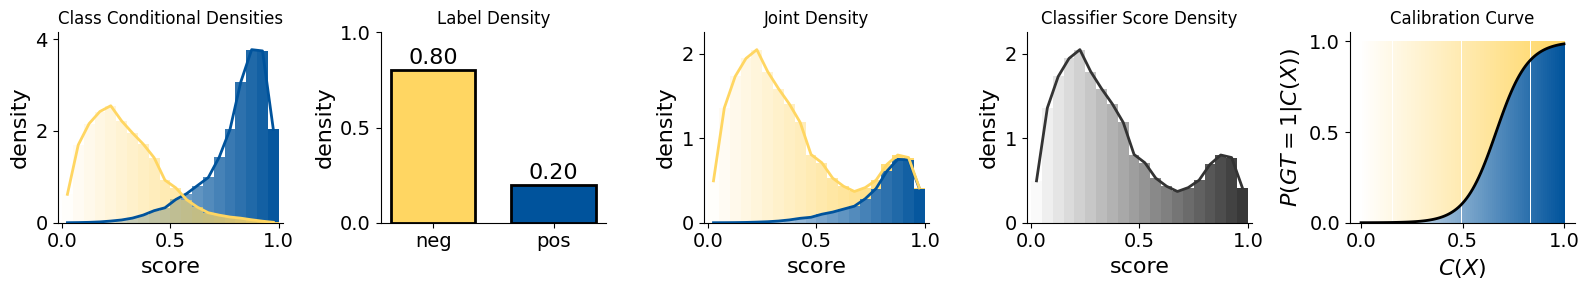

In [45]:
original_joint_distribution.plot_five_distributions()

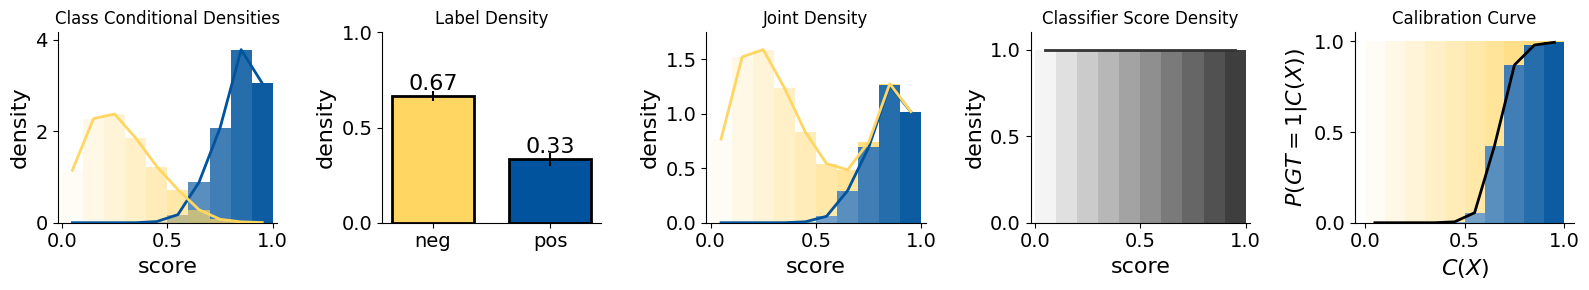

In [47]:
uniform_selected_dataset.profile_dataset(num_bin=10, selection_weights=uniform_selection_weights)

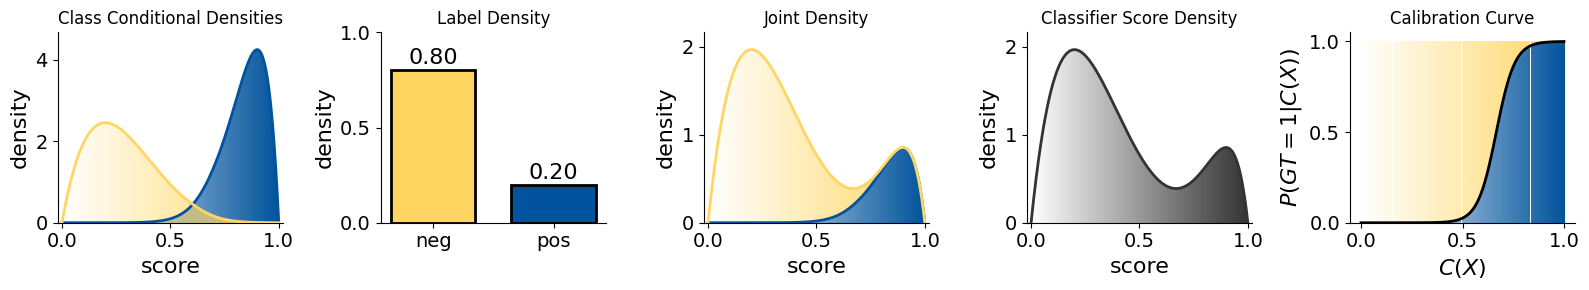

In [46]:
extrinsic_joint_distribution.plot_five_distributions()

## Intrinsic Labels $GT \rightarrow \mathcal{X}$

### If the data generating process is $GT \rightarrow \mathcal{X}$

Data generating process:
- For any GT positive items, their uncalibrated classifier scores $P(UC(X)|GT=1)$ follow a Beta distribution $Beta(\alpha_p, \beta_p)$. If $\alpha_p > \beta_p$, the distribution is left skewed.
- For any GT negative items, their uncalibrated classifier scores $P(UC(X)|GT=0)$ follow a Beta distribution $Beta(\alpha_n, \beta_n)$. If $\alpha_n < \beta_n$, the distribution is right skewed.

Random variable that we allow it to change between base and target period:
- Prevalence of GT positive items, $P(GT=1)$

Statistics that we can derive from the above parameters:
- Joint distribution between $UC(X)$ and $GT$, $JD(UC(X), GT)$
- Observed classifier score distribution, $P(UC(X))$
- Probability calibration curve, $P(CC(X)|UC(X))$

## Explaining with the sentiment analysis task

Crowdsourced labeling task: Given this tweet, do you think the writer is happy or not?
Prevalence estimation task: Estimating the fraction of positive tweets in a dataset

Data generating process:
- $\alpha_p=10, \beta_p=2$. For any GT positive tweets, their classifier scores $P(UC(X)|GT=1)$ follow a Beta distribution $Beta(10, 2)$.
- $\alpha_n=2, \beta_n=5$. For any GT negative tweets, their classifier scores $P(UC(X)|GT=0)$ follow a Beta distribution $Beta(2, 5)$.

Random variable that we allow it to change between base and target period:
- Prevalence of GT positive tweets. Assume that each person only posts one tweet. 
    * In the base period, the fraction of happy Twitter users is 20%, $p_p=0.2$. 
    * At the target period, the fraction of happy Twitter users is 70%, $p_p=0.7$. 

Statistics that we can generate from the above parameters:
- Joint distribution between $UC(X)$ and $GT$, $JD(UC(X), GT)$
- Observed classifier score distribution, $P(UC(X))$
- Probability calibration curve, $P(CC(X)|UC(X))$

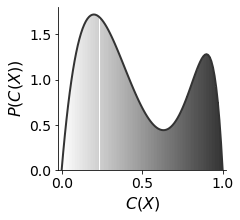

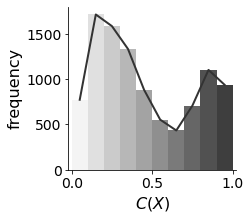

In [ ]:
mixture_distribution_rv = MixtureDistribution([stats.beta(10, 2), stats.beta(2, 5)], weights=[0.3, 0.7])
mixture_distribution_rv.plot_pdf()
mixture_distribution_rv.plot_hist(size=10000, color=ColorPalette.unknown_color)

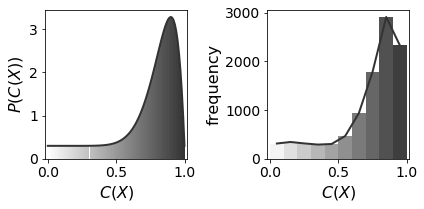

In [ ]:
mixture_distribution_rv = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.7, 0.3])

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.ravel()
    
mixture_distribution_rv.plot_pdf(ax=axes[0], color=ColorPalette.unknown_color)
mixture_distribution_rv.plot_hist(size=10000, ax=axes[1], color=ColorPalette.unknown_color)

plt.tight_layout()

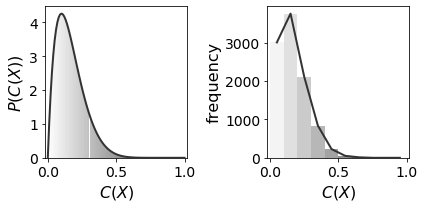

In [ ]:
single_distribution_rv = MixtureDistribution([stats.beta(2, 10)], weights=[1])

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.ravel()
    
single_distribution_rv.plot_pdf(ax=axes[0], color=ColorPalette.unknown_color)
single_distribution_rv.plot_hist(size=10000, ax=axes[1], color=ColorPalette.unknown_color)

plt.tight_layout()

## Instrinsic Label Generating Process $GT \rightarrow \mathcal{X}$

In [ ]:
from pyquantifier.distribution.class_conditional_density import ParametricConditionalDensities

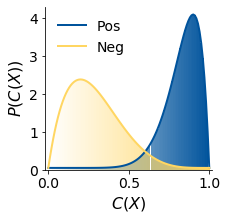

In [ ]:
good_pos_density = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_neg_density = MixtureDistribution([stats.beta(2, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_class_conditional_densities = ParametricConditionalDensities([good_pos_density, good_neg_density], ['Pos', 'Neg'])

good_class_conditional_densities.plot_pdf()

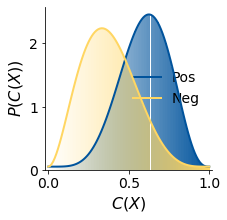

In [ ]:
bad_pos_density = MixtureDistribution([stats.beta(6, 4), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_neg_density = MixtureDistribution([stats.beta(3, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_class_conditional_densities = ParametricConditionalDensities([bad_pos_density, bad_neg_density], ['Pos', 'Neg'])

bad_class_conditional_densities.plot_pdf()

In [ ]:
from pyquantifier.distribution.label_density import ParametricLabelDensity

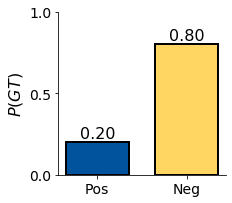

In [ ]:
label_density1 = ParametricLabelDensity([0.2, 0.8], ['Pos', 'Neg'])

label_density1.plot_bar()

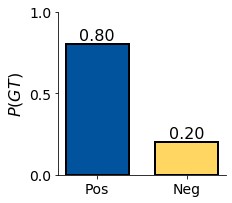

In [ ]:
label_density2 = ParametricLabelDensity([8, 2], ['Pos', 'Neg'])

label_density2.plot_bar()

In [ ]:
from pyquantifier.distribution.joint_density import ParametricJointDensity1

In [ ]:
# GT -> x data simulation configuration
class_names = ['Pos', 'Neg']

good_pos_density = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_neg_density = MixtureDistribution([stats.beta(2, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_class_conditional_densities = ParametricConditionalDensities([good_pos_density, good_neg_density], class_names)

label_density1 = ParametricLabelDensity([0.2, 0.8], class_names)

parametric_joint_distribution1 = ParametricJointDensity1(label_density1, good_class_conditional_densities)
sampled_data_points1 = parametric_joint_distribution1.rvs(size=10000)

print(f'sampled {len(sampled_data_points1)} data points from the joint distribution')
print(sampled_data_points1[:10])

sampled 10000 data points from the joint distribution
[(0.7543959952766598, 'Pos'), (0.7965580580098841, 'Pos'), (0.9369852279751224, 'Pos'), (0.9204135974057842, 'Pos'), (0.8178181983116973, 'Pos'), (0.8185884630430601, 'Pos'), (0.8852181638984504, 'Pos'), (0.7913619266374011, 'Pos'), (0.7208245615896814, 'Pos'), (0.8776393895051063, 'Pos')]


In [ ]:
from pyquantifier.distribution.joint_density import EmpiricalJointDistribution

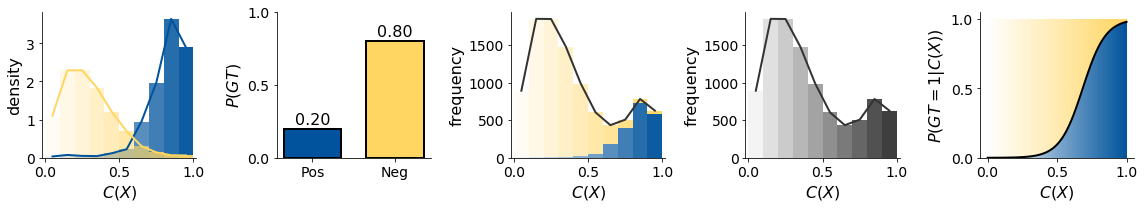

In [ ]:
empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points1)

empirical_joint_distribution.visualize_all_distribution()

We need a family tree of different modeling assumptions for the joint distribution

- Joint distribution (joint distribution between a continuous variable (cx) and a discrete variable (label))
-- get_density(cx, label)
-- 

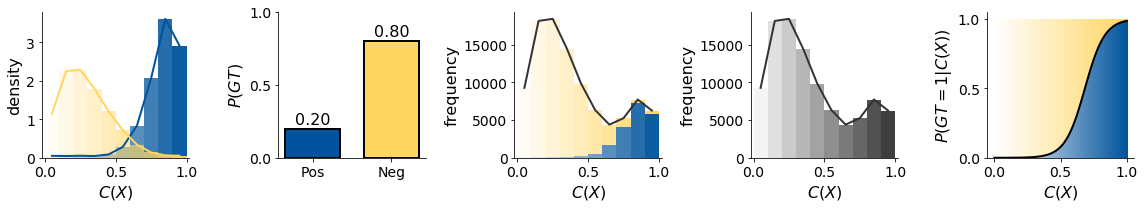

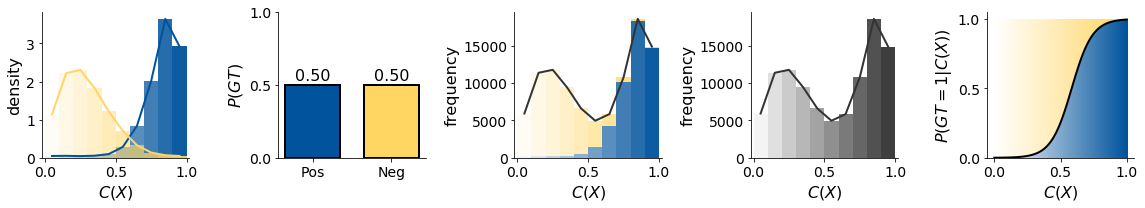

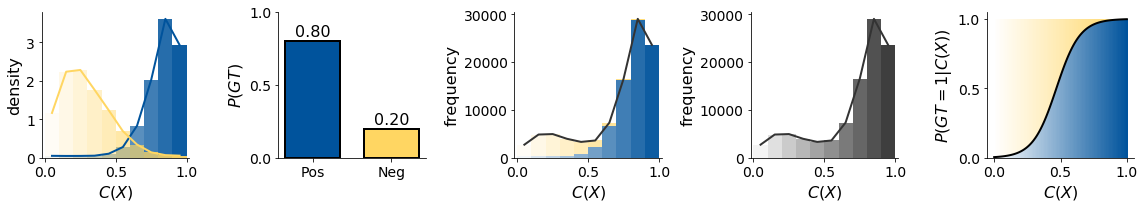

In [ ]:
class_names = ['Pos', 'Neg']
num_sample = 100000

good_pos_density = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_neg_density = MixtureDistribution([stats.beta(2, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_class_conditional_densities = ParametricConditionalDensities([good_pos_density, good_neg_density], class_names)

for pos_prevalence in [0.2, 0.5, 0.8]:
    label_density = ParametricLabelDensity([pos_prevalence, 1 - pos_prevalence], class_names)

    parametric_joint_distribution = ParametricJointDensity1(label_density, good_class_conditional_densities)
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

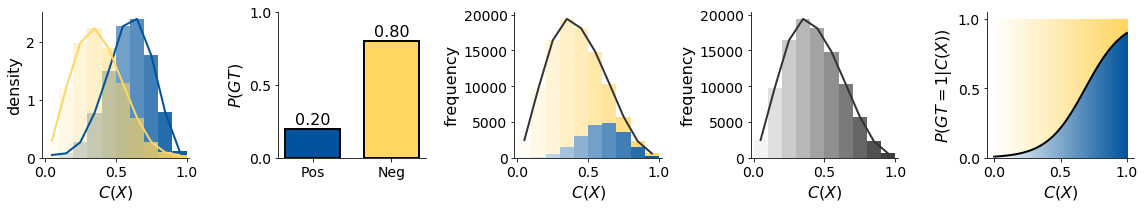

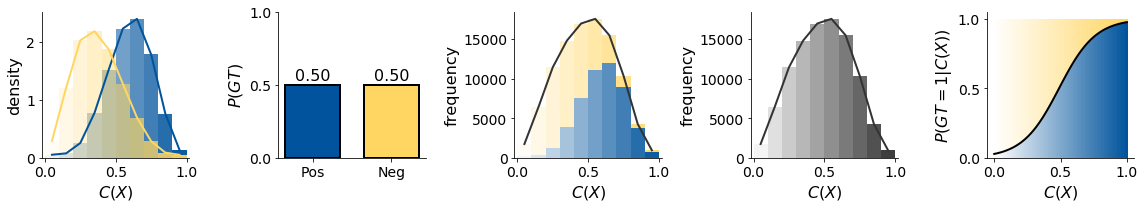

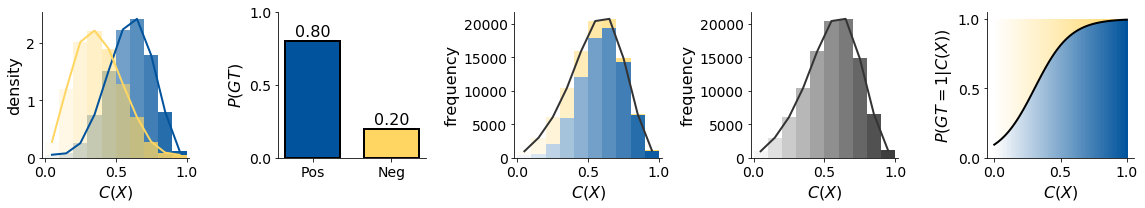

In [ ]:
class_names = ['Pos', 'Neg']
num_sample = 100000

bad_pos_density = MixtureDistribution([stats.beta(6, 4), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_neg_density = MixtureDistribution([stats.beta(3, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_class_conditional_densities = ParametricConditionalDensities([bad_pos_density, bad_neg_density], class_names)

for pos_prevalence in [0.2, 0.5, 0.8]:
    label_density = ParametricLabelDensity([pos_prevalence, 1 - pos_prevalence], class_names)

    parametric_joint_distribution = ParametricJointDensity1(label_density, bad_class_conditional_densities)
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

## Extrinsic Label Generating Process $\mathcal{X} \rightarrow GT$

In [ ]:
from pyquantifier.distribution.classifier_density import ParametricClassifierDensity

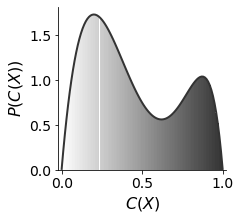

In [ ]:
any_density = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                  weights=[0.29, 0.7, 0.01])

any_classifier_density = ParametricClassifierDensity(any_density)

any_classifier_density.plot_pdf()

In [ ]:
from pyquantifier.distribution.calibration_curve import ParametricPlattScaling

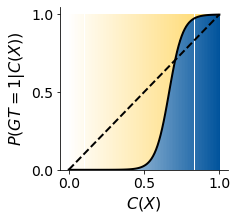

In [ ]:
w = 21.92
b = -14.61

good_calibration_curve = ParametricPlattScaling()
good_calibration_curve.set_params(w, b)

good_calibration_curve.plot_line(show_diagonal=True)

In [ ]:
from pyquantifier.distribution.joint_density import ParametricJointDensity2

In [ ]:
# x -> GT data simulation configuration

w = 21.92
b = -14.61

good_calibration_curve = ParametricPlattScaling()
good_calibration_curve.set_params(w, b)

any_density = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                  weights=[0.29, 0.7, 0.01])

any_classifier_density = ParametricClassifierDensity(any_density)

parametric_joint_distribution2 = ParametricJointDensity2(good_calibration_curve, any_density)
sampled_data_points2 = parametric_joint_distribution2.rvs(size=10000)

print(f'sampled {len(sampled_data_points2)} data points from the joint distribution')
print(sampled_data_points2[:10])

sampled 10000 data points from the joint distribution
[(0.47195693791195975, 'Neg'), (0.04736667172630213, 'Neg'), (0.8716723339848846, 'Pos'), (0.012999178275242636, 'Neg'), (0.03587333972651055, 'Neg'), (0.16797008294382437, 'Neg'), (0.26585856000076874, 'Neg'), (0.5460838732000706, 'Neg'), (0.8391551923880073, 'Neg'), (0.4854623130451082, 'Neg')]


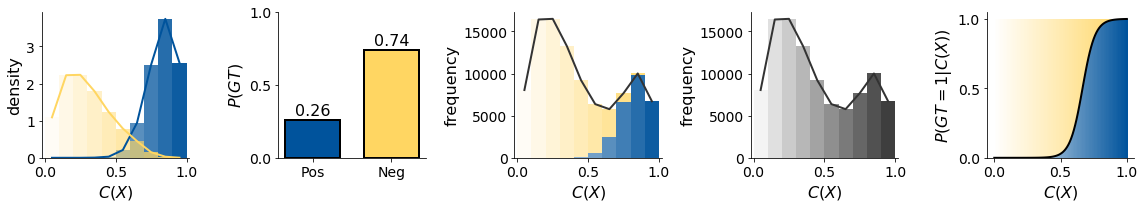

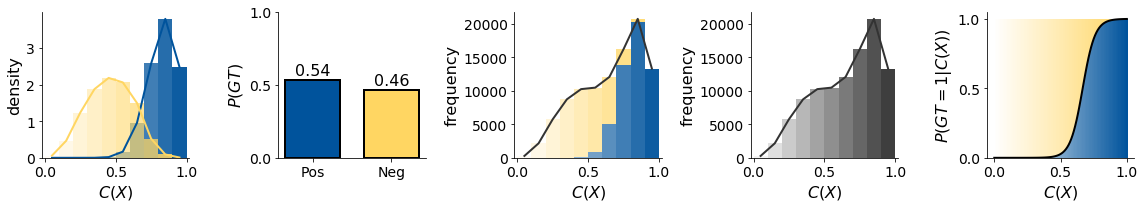

In [ ]:
num_sample = 100000

w = 21.92
b = -14.61

good_calibration_curve = ParametricPlattScaling()
good_calibration_curve.set_params(w, b)

any_density1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                   weights=[0.29, 0.7, 0.01])
any_density2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
                                   weights=[0.59, 0.4, 0.01])

for any_density in [any_density1, any_density2]:
    any_classifier_density = ParametricClassifierDensity(any_density)

    parametric_joint_distribution = ParametricJointDensity2(good_calibration_curve, any_density)
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

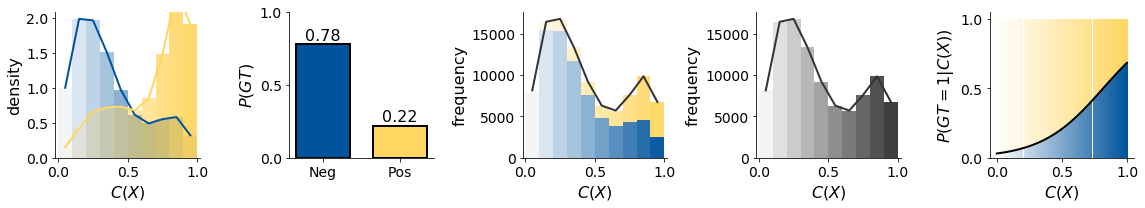

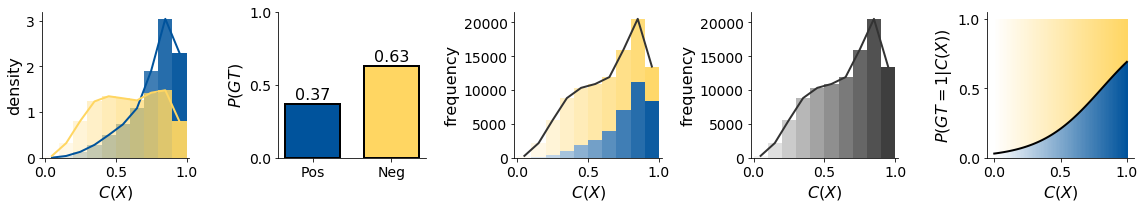

In [ ]:
num_sample = 100000

w = 4.26
b = -3.46

bad_calibration_curve = ParametricPlattScaling()
bad_calibration_curve.set_params(w, b)

any_density1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                   weights=[0.29, 0.7, 0.01])
any_density2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
                                   weights=[0.59, 0.4, 0.01])

for any_density in [any_density1, any_density2]:
    any_classifier_density = ParametricClassifierDensity(any_density)

    parametric_joint_distribution = ParametricJointDensity2(bad_calibration_curve, any_density)
    
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

In [ ]:
# # this plot is generated by simulation parameters: pos_gt_density and neg_gt_density
# # positive and negative density function
# def extrinsic_label_data_generator(prob_cali_func, 
#                                    all_cxs_list, 
#                                    period_list=['base', 'target'],
#                                    name='X to GT simulated data'):
#     """
#     This is a funcation that...
      
#     Attributes:
#         a_pos: alpha value of the Beta distribution for the GT positive items
#         b_pos: beta value of the Beta distribution for the GT positive items
#     """
    
#     # canvas configurations
#     num_period = len(period_list)
#     fig, axes = plt.subplots(1 + num_period, 5, figsize=(16, 3 + 3 * num_period))
    
#     # first row: plot the parametric calibration curve function
#     prob_cali_curve = prob_cali_func.get_calibrated_prob(fine_axis)
#     prob_cali_curve_w, prob_cali_curve_b = prob_cali_func.get_params()
#     prob_cali_func.plot_line(ax=axes[0, 0])
    
#     for row_idx, (all_cxs, period) in enumerate(zip(all_cxs_list, period_list)):        
#         row_idx += 1
        
#         all_ccxs = prob_cali_func.get_calibrated_prob(all_cxs)
        
#         all_labeled_data = []

#         for cx, ccx in zip(all_cxs, all_ccxs):
#             gt = random.choices([0, 1], [1-ccx, ccx])[0]
#             if gt:
#                 all_labeled_data.append((cx, 'Pos'))
#             else:
#                 all_labeled_data.append((cx, 'Neg'))
                
#         all_labels = [label for _, label in all_labeled_data]
        
#         # class-conditional density plot
#         class_conditional_density_obj = ClassConditionalDensities(all_labeled_data)
#         class_conditional_density_obj.plot_hist(ax=axes[row_idx, 0])

#         # label density plot
#         label_density_obj = LabelDensity(all_labels)
#         label_density_obj.plot_bar(ax=axes[row_idx, 1])
        
#         # joint distribution plot
#         joint_distribution_obj = JointDensity(all_labeled_data)
#         joint_distribution_obj.plot_hist(ax=axes[row_idx, 2])
        
#         # classifier density plot
#         classifier_density_obj = ClassifierDensity(all_cxs)
#         classifier_density_obj.plot_hist(ax=axes[row_idx, 3])

#         # calibration curve plot
#         calibration_curve_obj = PlattScaling()
#         calibration_curve_obj.fit(all_labeled_data)
#         calibration_curve_obj.plot_line(ax=axes[row_idx, 4])


#     for col_idx in [1, 2, 3, 4]:
#         axes[0, col_idx].set_axis_off()

#     for ax in axes.ravel():
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.tick_params(axis='both', which='major', labelsize=14)

#     plt.tight_layout()

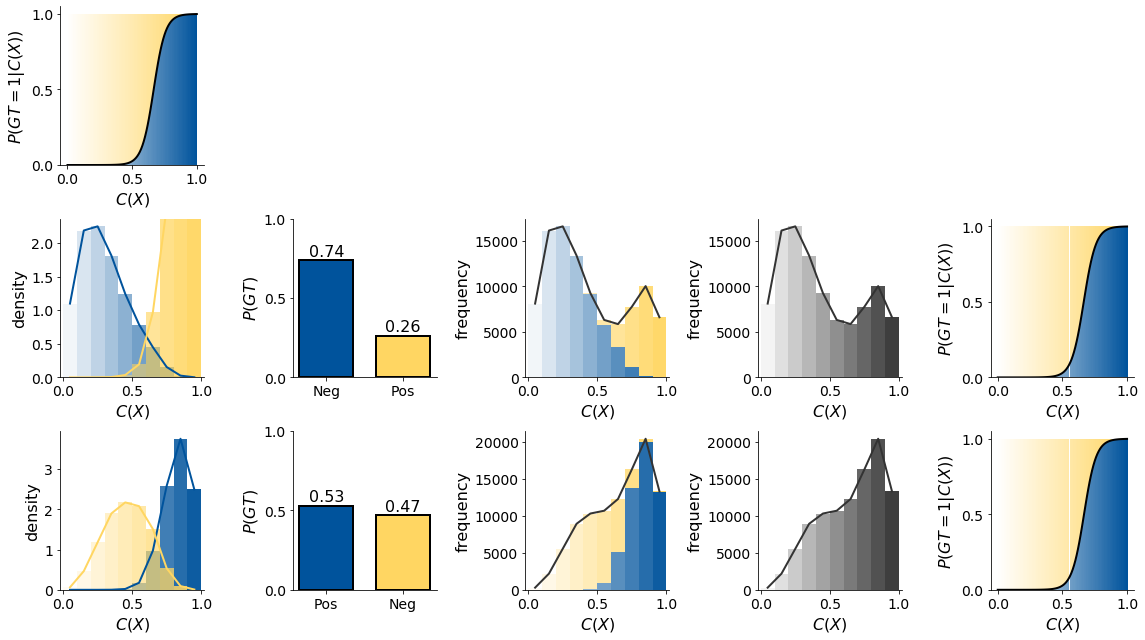

In [ ]:
# # GT -> x data simulation configuration
# w = 21.92
# b = -14.61

# good_lr_regressor = PlattScaling()
# good_lr_regressor.set_params(w, b)

# any_density_rvs1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)], 
#                                 weights=[0.29, 0.7, 0.01])

# any_density_rvs2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
#                                 weights=[0.59, 0.4, 0.01])

# extrinsic_label_data_generator(good_lr_regressor, 
#                                [any_density_rvs1.rvs(100000), any_density_rvs2.rvs(100000)],
#                                period_list=['base', 'target'],
#                                name='datasetnn2')

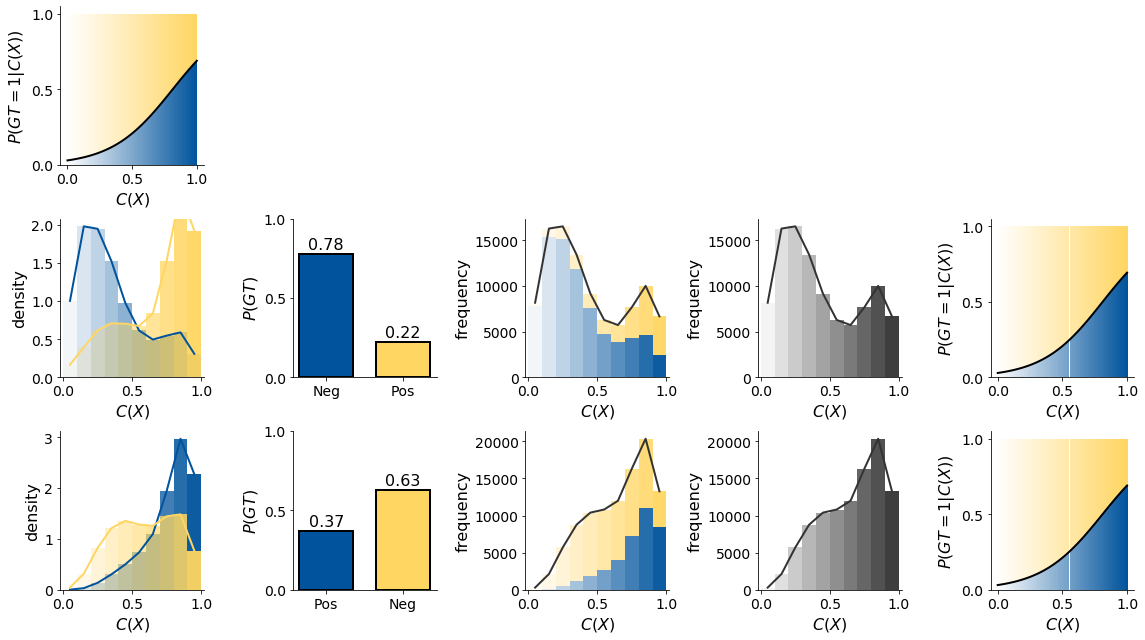

In [ ]:
# # GT -> x data simulation configuration
# w = 4.26
# b = -3.46

# bad_lr_regressor = PlattScaling()
# bad_lr_regressor.set_params(w, b)

# any_density_rvs1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)], 
#                                 weights=[0.29, 0.7, 0.01])

# any_density_rvs2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
#                                 weights=[0.59, 0.4, 0.01])

# extrinsic_label_data_generator(bad_lr_regressor, 
#                                [any_density_rvs1.rvs(100000), any_density_rvs2.rvs(100000)],
#                                period_list=['base', 'target'],
#                                name='datasetnn2')

In [ ]:
#         # data output module
#         uc_x_array = np.concatenate((pos_draws, neg_draws))
#         gt_list = [True] * num_pos + [False] * num_neg

#         url_array = np.random.choice(['yes', 'no'], size)
#         lang_array = np.random.choice(['en', 'es'], size)

#         output_df = pd.DataFrame(data={'has_url': url_array,
#                                        'lang': lang_array,
#                                        'C(X)': uc_x_array, 
#                                        'GT': gt_list})
#         output_df = output_df.sample(frac=1).reset_index(drop=True)
#         output_df.to_csv(f'../data/{name}_{period}.csv', sep=',', index=False)

In [ ]:
# def intrinsic_label_data_generator(positive_rvs, negative_rvs, 
#                                    p_p_list=[0.2, 0.7], 
#                                    size_list=[100000, 100000], 
#                                    period_list=['base', 'target'],
#                                    name='GT to X simulated data'):
#     """
#     This is a funcation that...
      
#     Attributes:
#         a_pos: alpha value of the Beta distribution for the GT positive items
#         b_pos: beta value of the Beta distribution for the GT positive items
#     """
    
#     # canvas configurations
#     num_period = len(p_p_list)
#     fig, axes = plt.subplots(1 + num_period, 5, figsize=(16, 3 + 3 * num_period))

#     # first row: plot the parametric class-conditional density function
#     color1, color2 = ColorPalette.CC2
#     positive_rvs.plot_pdf(ax=axes[0, 0], color=color1, label=f'$P(C(X)|GT=1)$')
#     negative_rvs.plot_pdf(ax=axes[0, 0], color=color2, label=f'$P(C(X)|GT=0)$')

#     axes[0, 0].set_ylabel('$P(C(X)|GT)$')
#     axes[0, 0].set_yticks([])
#     axes[0, 0].legend(frameon=False)
    
#     for row_idx, (p_p, size, period) in enumerate(zip(p_p_list, size_list, period_list)):
#         row_idx += 1

#         p_n = 1 - p_p
#         num_pos = int(size * p_p)
#         num_neg = size - num_pos
        
#         pos_draws = positive_rvs.rvs(num_pos)
#         neg_draws = negative_rvs.rvs(num_neg)
#         all_labeled_data = [(cx, 'Pos') for cx in pos_draws] + [(cx, 'Neg') for cx in neg_draws]
#         all_cxs = [cx for cx, _ in all_labeled_data]
#         all_labels = [label for _, label in all_labeled_data]

#         # class-conditional density plot
#         class_conditional_density_obj = ClassConditionalDensities(all_labeled_data)
#         class_conditional_density_obj.plot_hist(ax=axes[row_idx, 0])

#         # label density plot
#         label_density_obj = LabelDensity(all_labels)
#         label_density_obj.plot_bar(ax=axes[row_idx, 1])
        
#         # joint distribution plot
#         joint_distribution_obj = JointDensity(all_labeled_data)
#         joint_distribution_obj.plot_hist(ax=axes[row_idx, 2])
        
#         # classifier density plot
#         classifier_density_obj = ClassifierDensity(all_cxs)
#         classifier_density_obj.plot_hist(ax=axes[row_idx, 3])

#         # calibration curve plot
#         calibration_curve_obj = PlattScaling()
#         calibration_curve_obj.fit(all_labeled_data)
#         calibration_curve_obj.plot_line(ax=axes[row_idx, 4])


#     for col_idx in [1, 2, 3, 4]:
#         axes[0, col_idx].set_axis_off()

#     for ax in axes.ravel():
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.tick_params(axis='both', which='major')

#     plt.tight_layout()